In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

In [ ]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))
dataset_df.head(3)

In [ ]:
#去掉Id这一列
dataset_df=dataset_df.drop('Id',axis=1)
dataset_df.head(3)

In [ ]:
dataset_df.info()

In [ ]:
#观察房价的分布
#describe()描述目标变量的统计信息，均值、标准差、最小值~分位数~最大值
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9,8))
#bins统计直方图的条数，将数据分为100个区间
sns.distplot(dataset_df['SalePrice'],color='g',bins=100,hist_kws={'alpha':0.4})

In [ ]:
#数值型数据分布
#其中dtype('O')是object
list(set(dataset_df.dtypes.tolist()))

In [ ]:
#选择数据类型符合要求的列并返回
df_num=dataset_df.select_dtypes(include=['float64','int64'])
df_num.head()

In [ ]:
#观察所有数值型列的分布
df_num.hist(figsize=(16,20),bins=50,xlabelsize=8,ylabelsize=8);

# 数据预处理  
数据集中包含数值、类别和缺失数据，TF-DF支持处理这些数据，因此不需要太多的预处理  
这也是使用基于树的模型的一个优势

In [ ]:
import numpy as np
def split_dataset(dataset,test_ratio=0.30):
    #获取一个和数据集长度一样的随机数组,其中元素在[0,1)之间均匀分布
    #判断每个元素是否小于test_ratio，返回bool数组,其中True即为被选取到的测试集样本 
    test_indices=np.random.rand(len(dataset))<test_ratio
    #~test_indices对test_indices中的每个元素取反，即获取训练集元素
    return dataset[~test_indices],dataset[test_indices]
train_ds_pd,valid_ds_pd=split_dataset(dataset_df)
print("{} examples in training,{} examples in testing.".format(len(train_ds_pd),len(valid_ds_pd)))

In [ ]:
len(np.random.rand(len(dataset_df)))==len(dataset_df)

In [ ]:
#将pd.DataFrame数据类型转换为tf.data.Dataset类型
#由于随机森林默认是训练一个分类问题，在这里需要指定任务类型为回归
label='SalePrice'
train_ds=tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd,label=label,task=tfdf.keras.Task.REGRESSION)
valid_ds=tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd,label=label,task=tfdf.keras.Task.REGRESSION)

# 模型选择与训练

In [ ]:
#列举出Tensorflow基于决策树的模型
tfdf.keras.get_all_models()

In [ ]:
#使用在基准测试中排名靠前的超参数设置，设置任务模型为回归树
#rf=tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",task=tfdf.keras.Task.REGRESSION)
#rf=tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1",task=tfdf.keras.Task.REGRESSION)
#使用默认随机森林
rf=tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics=['mse'])#可选，设置损失函数

In [ ]:
#训练模型
rf.fit(x=train_ds)

In [ ]:
#模型可视化,选择一棵树进行可视化
tfdf.model_plotter.plot_model_in_colab(rf,tree_idx=0,max_depth=3)

## 使用箱外数据（OOB）和验证集评估模型  
随机森林中的每个决策树常基于大约67%的训练样本进行训练，因此每个决策树没有看见大约33%的样本  
OOB评估核心思想：
1.在训练集上评估随机森林 
2.对于每个样本，仅使用没有将它用于训练的决策树进行评估  
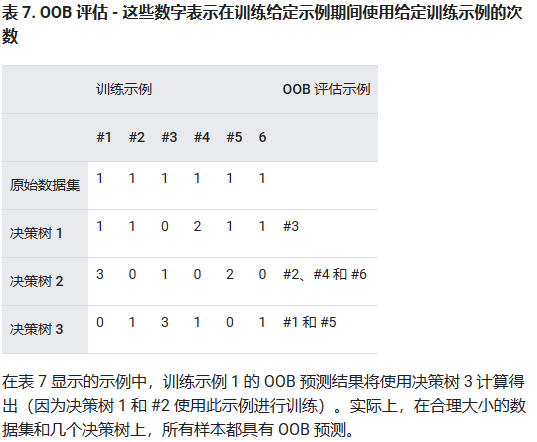

In [ ]:
import matplotlib.pyplot as plt
logs=rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs],[log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out of bag)")
plt.show()

In [ ]:
#获取评估指标
inspector = rf.make_inspector()
print(inspector.evaluation())
#以字典形式返回验证集评估结果
evaluation=rf.evaluate(x=valid_ds,return_dict=True)
for name,value in evaluation.items():
    print(f"{name}:{value:.4f}")

In [ ]:
#特征重要性
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

In [ ]:
inspector.variable_importances()["NUM_AS_ROOT"]

In [ ]:
plt.figure(figsize=(10, 5))
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

#提取特征重要性的名字和对应值
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
#将特征按重要性降序排列
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()#自动调整子图防止重叠


for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

# 提交

In [ ]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')#将Id列弹出存入ids

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()
output.to_csv('/kaggle/working/submission.csv',index=False)

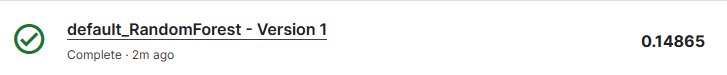